# CodeBERT
## Luis Arturo Rendon Inarritu
### A01703572 

### Imports

In [25]:
import torch
from torch import nn
from torch.optim import AdamW
from os.path import join as joinpath
import pandas as pd
import matplotlib.pyplot as plt
from transformers import(
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup)

from transformers.optimization import get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm, trange
import numpy as np

### Model name and dataset read

In [26]:
MODEL_NAME = "huggingface/CodeBERTa-small-v1"
plag_dataset = pd.read_csv(joinpath('..', 'plag_dataset.csv'))

In [27]:
print(f'Dataset lenght {len(plag_dataset)}')
plag_dataset.head()

Dataset lenght 1371


,Unnamed: 0,original,untrusted,plagiarism
0,0,public class T1 { public static void main(Str...,import java.util.Scanner; public class Soal1 ...,0
1,1,public class T1 { public static void main(Str...,public class Kasus1L1 { public stati...,1
2,2,public class T1 { public static void main(Str...,public class Kasus1L3 { public stati...,1
3,3,public class T1 { public static void main(Str...,public class Kasus1L6 { public ...,1
4,4,public class T1 { public static void main(Str...,public class L1 { public static void main...,1


### Divide dataset in train 80% and test 20%

In [28]:
train, test = train_test_split(plag_dataset, test_size=0.2, random_state=69)

In [29]:
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 1096
Test size: 275


## Tokenization
This section is meant to show the tokenization process for the bert transformer

In [30]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [31]:
print(tokenizer)

RobertaTokenizerFast(name_or_path='huggingface/CodeBERTa-small-v1', vocab_size=52000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)


In [32]:
original_string = 'public static void main(String[] args){}'
print(f'Original string: {original_string}')

token_ids = tokenizer.encode(original_string)
print(f'Token IDs: {token_ids}')

tokens = tokenizer.convert_ids_to_tokens(token_ids)
print(f'Tokens: {tokens}')

Original string: public static void main(String[] args){}
Token IDs: [0, 479, 807, 954, 3923, 12, 570, 751, 1327, 46561, 2]
Tokens: ['<s>', 'public', 'Ġstatic', 'Ġvoid', 'Ġmain', '(', 'String', '[]', 'Ġargs', '){}', '</s>']


In [33]:
sourceCode = plag_dataset['original'].iloc[0]

token_ids = tokenizer.encode_plus(
  sourceCode,
  max_length = 512,
  padding = 'max_length',
  truncation = True,
  return_tensors = 'pt',
)

print('Token IDs:')
print(token_ids['input_ids'])

print('Attention Mask:')
print(token_ids['attention_mask'])


Token IDs:
tensor([[    0,  1291,  1299,   461,    21,   284,  1291,   807,   954,  3923,
            12,   570,   751,  1327,    13,   284,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,   302,   302,   225,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     

# Model definition

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Loading

In [35]:
class TokenizedDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        # just keep the texts and the label
        self.original  = df["original"].tolist()
        self.untrusted = df["untrusted"].tolist()
        self.labels    = df["plagiarism"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "code_a": self.original[idx],
            "code_b": self.untrusted[idx],
            "label":  self.labels[idx],
        }

In [36]:
def collate_fn(batch, max_len=256):
    texts_a = [item['code_a'] for item in batch]
    texts_b = [item['code_b'] for item in batch]
    labels  = torch.tensor([item['label'] for item in batch])

    enc = tokenizer(
        texts_a,
        texts_b,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    enc['labels'] = labels
    return enc


In [37]:
class EmbeddedDataset(Dataset):
  def __init__(self, path):
    data = torch.load(path)
    self.originals = data['originals']
    self.untrusted = data['untrusted']
    self.labels = data['labels']

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
      'original': self.originals[idx],
      'untrusted': self.untrusted[idx],
      'label': self.labels[idx],
    }

In [38]:
train_dataset = TokenizedDataset(train)
test_dataset = TokenizedDataset(test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=16,
                          collate_fn=collate_fn)


# Training

### Choose device for training, NVIDIA, APPLE, or processor

In [39]:
def best_device() -> torch.device:
    """mps → cuda → cpu"""
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [40]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for batch in tqdm(dataloader, desc="Eval", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss   = outputs.loss
        logits = outputs.logits
        labels = batch["labels"]

        total_loss   += loss.item() * labels.size(0)
        total_correct += (logits.argmax(-1) == labels).sum().item()
        total_samples += labels.size(0)

    return {
        "loss": total_loss / total_samples,
        "accuracy": total_correct / total_samples
    }

## Config and history (for saving data through trainig)

In [41]:
EPOCHS = 100
history = {k: [] for k in (
    "train_loss", "test_loss", "train_accuracy", "test_accuracy"
)}

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * EPOCHS,
)

device = best_device()
print(f"Using device → {device}", flush=True)
model.to(device)

Using device → cuda


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

## Training loop

In [42]:
for epoch in trange(EPOCHS, desc="Epochs"):
    model.train()

    prog = tqdm(
        enumerate(train_loader, 1),
        total=len(train_loader),
        desc=f"Train {epoch+1}/{EPOCHS}",
        leave=False,
    )

    for _, batch in prog:
        batch = {k: v.to(device) for k, v in batch.items()}
        loss  = model(**batch).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        prog.set_postfix(loss=f"{loss.item():.4f}")

    # ─── end of epoch ──────────────────────────────────────────────
    train_metrics = evaluate(model, train_loader, device)
    test_metrics  = evaluate(model, test_loader,  device)

    history["train_loss"].append(train_metrics["loss"])
    history["train_accuracy"].append(train_metrics["accuracy"])
    history["test_loss"].append(test_metrics["loss"])
    history["test_accuracy"].append(test_metrics["accuracy"])

    print(
        f"Epoch {epoch+1:02d} | "
        f"train loss {train_metrics['loss']:.4f} – acc {train_metrics['accuracy']:.3f} | "
        f"test loss  {test_metrics['loss']:.4f} – acc {test_metrics['accuracy']:.3f}",
        flush=True,
    )


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 01 | train loss 0.5348 – acc 0.754 | test loss  0.5731 – acc 0.738


Epochs:   1%|          | 1/100 [00:20<34:02, 20.63s/it]

Epoch 02 | train loss 0.3748 – acc 0.861 | test loss  0.4431 – acc 0.818


Epochs:   2%|▏         | 2/100 [00:42<34:34, 21.17s/it]

Epoch 03 | train loss 0.3320 – acc 0.870 | test loss  0.5104 – acc 0.800


Epochs:   3%|▎         | 3/100 [01:02<33:40, 20.83s/it]

Epoch 04 | train loss 0.1425 – acc 0.957 | test loss  0.3371 – acc 0.876


Epochs:   4%|▍         | 4/100 [01:22<33:02, 20.65s/it]

Epoch 05 | train loss 0.1157 – acc 0.969 | test loss  0.3109 – acc 0.895


Epochs:   5%|▌         | 5/100 [01:43<32:36, 20.59s/it]

Epoch 06 | train loss 0.0643 – acc 0.982 | test loss  0.3727 – acc 0.862


Epochs:   6%|▌         | 6/100 [02:03<32:07, 20.51s/it]

Epoch 07 | train loss 0.0602 – acc 0.979 | test loss  0.4678 – acc 0.876


Epochs:   7%|▋         | 7/100 [02:24<31:43, 20.47s/it]

Epoch 08 | train loss 0.0520 – acc 0.981 | test loss  0.4669 – acc 0.836


Epochs:   8%|▊         | 8/100 [02:44<31:17, 20.41s/it]

Epoch 09 | train loss 0.0127 – acc 0.996 | test loss  0.4591 – acc 0.884


Epochs:   9%|▉         | 9/100 [03:04<30:52, 20.36s/it]

Epoch 10 | train loss 0.0460 – acc 0.980 | test loss  0.5882 – acc 0.858


Epochs:  10%|█         | 10/100 [03:25<30:33, 20.37s/it]

Epoch 11 | train loss 0.0110 – acc 0.996 | test loss  0.4750 – acc 0.895


Epochs:  11%|█         | 11/100 [03:46<30:37, 20.65s/it]

Epoch 12 | train loss 0.0064 – acc 0.998 | test loss  0.5704 – acc 0.891


Epochs:  12%|█▏        | 12/100 [04:06<30:14, 20.62s/it]

Epoch 13 | train loss 0.0139 – acc 0.993 | test loss  0.5855 – acc 0.876


Epochs:  13%|█▎        | 13/100 [04:27<29:50, 20.58s/it]

Epoch 14 | train loss 0.0117 – acc 0.998 | test loss  0.4490 – acc 0.891


Epochs:  14%|█▍        | 14/100 [04:47<29:23, 20.50s/it]

Epoch 15 | train loss 0.0062 – acc 0.996 | test loss  0.5463 – acc 0.873


Epochs:  15%|█▌        | 15/100 [05:08<29:03, 20.51s/it]

Epoch 16 | train loss 0.0046 – acc 0.998 | test loss  0.6490 – acc 0.884


Epochs:  16%|█▌        | 16/100 [05:28<28:40, 20.48s/it]

Epoch 17 | train loss 0.0164 – acc 0.994 | test loss  0.5374 – acc 0.869


Epochs:  17%|█▋        | 17/100 [05:49<28:17, 20.45s/it]

Epoch 18 | train loss 0.0040 – acc 0.998 | test loss  0.6090 – acc 0.880


Epochs:  18%|█▊        | 18/100 [06:09<27:54, 20.42s/it]

Epoch 19 | train loss 0.0072 – acc 0.999 | test loss  0.5670 – acc 0.895


Epochs:  19%|█▉        | 19/100 [06:29<27:34, 20.42s/it]

Epoch 20 | train loss 0.0111 – acc 0.998 | test loss  0.5837 – acc 0.891


Epochs:  20%|██        | 20/100 [06:50<27:22, 20.53s/it]

Epoch 21 | train loss 0.0019 – acc 0.999 | test loss  0.5944 – acc 0.887


Epochs:  21%|██        | 21/100 [07:10<26:43, 20.30s/it]

Epoch 22 | train loss 0.0013 – acc 0.999 | test loss  0.6711 – acc 0.895


Epochs:  22%|██▏       | 22/100 [07:30<26:11, 20.15s/it]

Epoch 23 | train loss 0.0010 – acc 1.000 | test loss  0.6671 – acc 0.905


Epochs:  23%|██▎       | 23/100 [07:50<25:44, 20.06s/it]

Epoch 24 | train loss 0.0007 – acc 1.000 | test loss  0.6865 – acc 0.876


Epochs:  24%|██▍       | 24/100 [08:09<25:16, 19.95s/it]

Epoch 25 | train loss 0.0006 – acc 1.000 | test loss  0.7975 – acc 0.880


Epochs:  25%|██▌       | 25/100 [08:29<24:55, 19.94s/it]

Epoch 26 | train loss 0.0091 – acc 0.998 | test loss  0.6951 – acc 0.880


Epochs:  26%|██▌       | 26/100 [08:49<24:33, 19.91s/it]

Epoch 27 | train loss 0.0062 – acc 0.998 | test loss  0.5770 – acc 0.876


Epochs:  27%|██▋       | 27/100 [09:09<24:09, 19.86s/it]

Epoch 28 | train loss 0.0097 – acc 0.997 | test loss  0.6581 – acc 0.873


Epochs:  28%|██▊       | 28/100 [09:29<24:04, 20.07s/it]

Epoch 29 | train loss 0.0299 – acc 0.989 | test loss  0.7823 – acc 0.833


Epochs:  29%|██▉       | 29/100 [09:49<23:44, 20.06s/it]

Epoch 30 | train loss 0.0578 – acc 0.984 | test loss  0.8871 – acc 0.822


Epochs:  30%|███       | 30/100 [10:09<23:19, 19.99s/it]

Epoch 31 | train loss 0.0027 – acc 0.999 | test loss  0.5606 – acc 0.884


Epochs:  31%|███       | 31/100 [10:29<22:56, 19.94s/it]

Epoch 32 | train loss 0.0004 – acc 1.000 | test loss  0.6104 – acc 0.887


Epochs:  32%|███▏      | 32/100 [10:49<22:30, 19.87s/it]

Epoch 33 | train loss 0.0018 – acc 0.999 | test loss  0.6540 – acc 0.884


Epochs:  33%|███▎      | 33/100 [11:09<22:12, 19.89s/it]

Epoch 34 | train loss 0.0002 – acc 1.000 | test loss  0.6597 – acc 0.880


Epochs:  34%|███▍      | 34/100 [11:28<21:49, 19.84s/it]

Epoch 35 | train loss 0.0001 – acc 1.000 | test loss  0.6756 – acc 0.887


Epochs:  35%|███▌      | 35/100 [11:48<21:27, 19.81s/it]

Epoch 36 | train loss 0.0001 – acc 1.000 | test loss  0.7053 – acc 0.880


Epochs:  36%|███▌      | 36/100 [12:08<21:09, 19.83s/it]

Epoch 37 | train loss 0.0001 – acc 1.000 | test loss  0.7210 – acc 0.880


Epochs:  37%|███▋      | 37/100 [12:28<20:47, 19.79s/it]

Epoch 38 | train loss 0.0001 – acc 1.000 | test loss  0.7345 – acc 0.880


Epochs:  38%|███▊      | 38/100 [12:47<20:26, 19.77s/it]

Epoch 39 | train loss 0.0001 – acc 1.000 | test loss  0.7424 – acc 0.880


Epochs:  39%|███▉      | 39/100 [13:08<20:27, 20.13s/it]

Epoch 40 | train loss 0.0001 – acc 1.000 | test loss  0.7497 – acc 0.884


Epochs:  40%|████      | 40/100 [13:28<19:59, 19.99s/it]

Epoch 41 | train loss 0.0001 – acc 1.000 | test loss  0.7447 – acc 0.887


Epochs:  41%|████      | 41/100 [13:48<19:37, 19.96s/it]

Epoch 42 | train loss 0.0001 – acc 1.000 | test loss  0.7632 – acc 0.884


Epochs:  42%|████▏     | 42/100 [14:08<19:13, 19.89s/it]

Epoch 43 | train loss 0.0000 – acc 1.000 | test loss  0.7695 – acc 0.884


Epochs:  43%|████▎     | 43/100 [14:28<18:53, 19.88s/it]

Epoch 44 | train loss 0.0000 – acc 1.000 | test loss  0.7818 – acc 0.876


Epochs:  44%|████▍     | 44/100 [14:47<18:33, 19.89s/it]

Epoch 45 | train loss 0.0000 – acc 1.000 | test loss  0.7838 – acc 0.876


Epochs:  45%|████▌     | 45/100 [15:07<18:11, 19.84s/it]

Epoch 46 | train loss 0.0037 – acc 0.999 | test loss  0.8410 – acc 0.880


Epochs:  46%|████▌     | 46/100 [15:27<17:51, 19.85s/it]

Epoch 47 | train loss 0.0061 – acc 0.998 | test loss  0.6779 – acc 0.873


Epochs:  47%|████▋     | 47/100 [15:47<17:28, 19.79s/it]

Epoch 48 | train loss 0.0006 – acc 1.000 | test loss  0.7095 – acc 0.869


Epochs:  48%|████▊     | 48/100 [16:06<17:06, 19.75s/it]

Epoch 49 | train loss 0.0083 – acc 0.996 | test loss  0.6186 – acc 0.880


Epochs:  49%|████▉     | 49/100 [16:26<16:48, 19.78s/it]

Epoch 50 | train loss 0.0002 – acc 1.000 | test loss  0.6385 – acc 0.898


Epochs:  50%|█████     | 50/100 [16:46<16:25, 19.71s/it]

Epoch 51 | train loss 0.0006 – acc 1.000 | test loss  0.6627 – acc 0.873


Epochs:  51%|█████     | 51/100 [17:05<16:06, 19.72s/it]

Epoch 52 | train loss 0.0002 – acc 1.000 | test loss  0.6372 – acc 0.891


Epochs:  52%|█████▏    | 52/100 [17:25<15:47, 19.73s/it]

Epoch 53 | train loss 0.0001 – acc 1.000 | test loss  0.6631 – acc 0.895


Epochs:  53%|█████▎    | 53/100 [17:45<15:24, 19.67s/it]

Epoch 54 | train loss 0.0001 – acc 1.000 | test loss  0.6582 – acc 0.895


Epochs:  54%|█████▍    | 54/100 [18:05<15:07, 19.72s/it]

Epoch 55 | train loss 0.0001 – acc 1.000 | test loss  0.6892 – acc 0.869


Epochs:  55%|█████▌    | 55/100 [18:24<14:47, 19.71s/it]

Epoch 56 | train loss 0.0002 – acc 1.000 | test loss  0.7390 – acc 0.880


Epochs:  56%|█████▌    | 56/100 [18:44<14:26, 19.69s/it]

Epoch 57 | train loss 0.0001 – acc 1.000 | test loss  0.7434 – acc 0.873


Epochs:  57%|█████▋    | 57/100 [19:04<14:07, 19.72s/it]

Epoch 58 | train loss 0.0001 – acc 1.000 | test loss  0.7646 – acc 0.858


Epochs:  58%|█████▊    | 58/100 [19:23<13:45, 19.66s/it]

Epoch 59 | train loss 0.0001 – acc 1.000 | test loss  0.7492 – acc 0.869


Epochs:  59%|█████▉    | 59/100 [19:43<13:27, 19.69s/it]

Epoch 60 | train loss 0.0001 – acc 1.000 | test loss  0.7538 – acc 0.873


Epochs:  60%|██████    | 60/100 [20:03<13:07, 19.69s/it]

Epoch 61 | train loss 0.0000 – acc 1.000 | test loss  0.7575 – acc 0.880


Epochs:  61%|██████    | 61/100 [20:22<12:46, 19.65s/it]

Epoch 62 | train loss 0.0000 – acc 1.000 | test loss  0.7715 – acc 0.865


Epochs:  62%|██████▏   | 62/100 [20:42<12:28, 19.69s/it]

Epoch 63 | train loss 0.0013 – acc 1.000 | test loss  0.7725 – acc 0.880


Epochs:  63%|██████▎   | 63/100 [21:02<12:07, 19.67s/it]

Epoch 64 | train loss 0.0004 – acc 1.000 | test loss  0.7944 – acc 0.873


Epochs:  64%|██████▍   | 64/100 [21:21<11:47, 19.66s/it]

Epoch 65 | train loss 0.0001 – acc 1.000 | test loss  0.8074 – acc 0.891


Epochs:  65%|██████▌   | 65/100 [21:41<11:29, 19.70s/it]

Epoch 66 | train loss 0.0003 – acc 1.000 | test loss  0.7952 – acc 0.869


Epochs:  66%|██████▌   | 66/100 [22:01<11:08, 19.65s/it]

Epoch 67 | train loss 0.0001 – acc 1.000 | test loss  0.8027 – acc 0.876


Epochs:  67%|██████▋   | 67/100 [22:20<10:49, 19.68s/it]

Epoch 68 | train loss 0.0000 – acc 1.000 | test loss  0.8146 – acc 0.884


Epochs:  68%|██████▊   | 68/100 [22:40<10:29, 19.68s/it]

Epoch 69 | train loss 0.0000 – acc 1.000 | test loss  0.8128 – acc 0.884


Epochs:  69%|██████▉   | 69/100 [23:00<10:08, 19.64s/it]

Epoch 70 | train loss 0.0000 – acc 1.000 | test loss  0.8073 – acc 0.880


Epochs:  70%|███████   | 70/100 [23:19<09:50, 19.69s/it]

Epoch 71 | train loss 0.0000 – acc 1.000 | test loss  0.8118 – acc 0.884


Epochs:  71%|███████   | 71/100 [23:39<09:29, 19.65s/it]

Epoch 72 | train loss 0.0000 – acc 1.000 | test loss  0.8132 – acc 0.876


Epochs:  72%|███████▏  | 72/100 [23:59<09:09, 19.64s/it]

Epoch 73 | train loss 0.0000 – acc 1.000 | test loss  0.8159 – acc 0.880


Epochs:  73%|███████▎  | 73/100 [24:18<08:51, 19.68s/it]

Epoch 74 | train loss 0.0000 – acc 1.000 | test loss  0.8193 – acc 0.887


Epochs:  74%|███████▍  | 74/100 [24:38<08:30, 19.64s/it]

Epoch 75 | train loss 0.0000 – acc 1.000 | test loss  0.8257 – acc 0.880


Epochs:  75%|███████▌  | 75/100 [24:58<08:11, 19.67s/it]

Epoch 76 | train loss 0.0000 – acc 1.000 | test loss  0.8294 – acc 0.880


Epochs:  76%|███████▌  | 76/100 [25:17<07:52, 19.68s/it]

Epoch 77 | train loss 0.0000 – acc 1.000 | test loss  0.8332 – acc 0.880


Epochs:  77%|███████▋  | 77/100 [25:37<07:32, 19.65s/it]

Epoch 78 | train loss 0.0000 – acc 1.000 | test loss  0.8355 – acc 0.884


Epochs:  78%|███████▊  | 78/100 [25:57<07:13, 19.69s/it]

Epoch 79 | train loss 0.0000 – acc 1.000 | test loss  0.8381 – acc 0.887


Epochs:  79%|███████▉  | 79/100 [26:16<06:52, 19.65s/it]

Epoch 80 | train loss 0.0000 – acc 1.000 | test loss  0.8405 – acc 0.887


Epochs:  80%|████████  | 80/100 [26:36<06:32, 19.65s/it]

Epoch 81 | train loss 0.0000 – acc 1.000 | test loss  0.8524 – acc 0.876


Epochs:  81%|████████  | 81/100 [26:56<06:14, 19.69s/it]

Epoch 82 | train loss 0.0000 – acc 1.000 | test loss  0.8557 – acc 0.876


Epochs:  82%|████████▏ | 82/100 [27:15<05:53, 19.65s/it]

Epoch 83 | train loss 0.0000 – acc 1.000 | test loss  0.8614 – acc 0.887


Epochs:  83%|████████▎ | 83/100 [27:35<05:34, 19.68s/it]

Epoch 84 | train loss 0.0000 – acc 1.000 | test loss  0.8647 – acc 0.887


Epochs:  84%|████████▍ | 84/100 [27:55<05:14, 19.67s/it]

Epoch 85 | train loss 0.0000 – acc 1.000 | test loss  0.8670 – acc 0.884


Epochs:  85%|████████▌ | 85/100 [28:14<04:54, 19.65s/it]

Epoch 86 | train loss 0.0000 – acc 1.000 | test loss  0.8687 – acc 0.884


Epochs:  86%|████████▌ | 86/100 [28:34<04:35, 19.68s/it]

Epoch 87 | train loss 0.0000 – acc 1.000 | test loss  0.8703 – acc 0.884


Epochs:  87%|████████▋ | 87/100 [28:54<04:15, 19.66s/it]

Epoch 88 | train loss 0.0000 – acc 1.000 | test loss  0.8722 – acc 0.884


Epochs:  88%|████████▊ | 88/100 [29:13<03:55, 19.66s/it]

Epoch 89 | train loss 0.0000 – acc 1.000 | test loss  0.8738 – acc 0.884


Epochs:  89%|████████▉ | 89/100 [29:33<03:36, 19.70s/it]

Epoch 90 | train loss 0.0000 – acc 1.000 | test loss  0.8749 – acc 0.884


Epochs:  90%|█████████ | 90/100 [29:53<03:16, 19.66s/it]

Epoch 91 | train loss 0.0000 – acc 1.000 | test loss  0.8761 – acc 0.884


Epochs:  91%|█████████ | 91/100 [30:12<02:57, 19.68s/it]

Epoch 92 | train loss 0.0000 – acc 1.000 | test loss  0.8775 – acc 0.884


Epochs:  92%|█████████▏| 92/100 [30:32<02:37, 19.69s/it]

Epoch 93 | train loss 0.0000 – acc 1.000 | test loss  0.8786 – acc 0.884


Epochs:  93%|█████████▎| 93/100 [30:53<02:20, 20.09s/it]

Epoch 94 | train loss 0.0000 – acc 1.000 | test loss  0.8794 – acc 0.884


Epochs:  94%|█████████▍| 94/100 [31:13<02:00, 20.04s/it]

Epoch 95 | train loss 0.0000 – acc 1.000 | test loss  0.8801 – acc 0.884


Epochs:  95%|█████████▌| 95/100 [31:33<01:39, 19.95s/it]

Epoch 96 | train loss 0.0000 – acc 1.000 | test loss  0.8805 – acc 0.884


Epochs:  96%|█████████▌| 96/100 [31:53<01:19, 19.92s/it]

Epoch 97 | train loss 0.0000 – acc 1.000 | test loss  0.8816 – acc 0.884


Epochs:  97%|█████████▋| 97/100 [32:12<00:59, 19.89s/it]

Epoch 98 | train loss 0.0000 – acc 1.000 | test loss  0.8818 – acc 0.887


Epochs:  98%|█████████▊| 98/100 [32:32<00:39, 19.84s/it]

Epoch 99 | train loss 0.0000 – acc 1.000 | test loss  0.8822 – acc 0.887


Epochs:  99%|█████████▉| 99/100 [32:52<00:19, 19.87s/it]

Epoch 100 | train loss 0.0000 – acc 1.000 | test loss  0.8822 – acc 0.887


Epochs: 100%|██████████| 100/100 [33:12<00:00, 19.92s/it]


In [43]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits  # shape [B,2]
        preds = logits.argmax(1)
        ...


# Plotting


In [44]:
print(history)

{'train_loss': [0.5347723723763097, 0.37476535021823687, 0.33199627686591043, 0.14253247387870385, 0.11572946874547178, 0.06426135672215563, 0.06018681442161111, 0.05195295763793435, 0.012688380548812068, 0.046019777398977946, 0.010976847745546133, 0.006446093081642812, 0.013924536828451321, 0.011749612876166502, 0.006168081630769111, 0.004632404993711393, 0.016373210819013228, 0.00403441595587876, 0.007200685566708439, 0.011068108403438321, 0.0019272628973618857, 0.0013140132892910854, 0.0009784298388323114, 0.0006641872563054377, 0.0005789196929583381, 0.00910538977949309, 0.006181376417300045, 0.009749602632007364, 0.029945721602097942, 0.057788260477589934, 0.0026959548587485956, 0.00037525149052078925, 0.0018088003421027254, 0.0001938640037283852, 0.0001419318870604752, 0.00011148255486865562, 9.264803621544075e-05, 8.110206091014268e-05, 7.249205213900058e-05, 6.549566151212262e-05, 6.0060621497567987e-05, 5.3137429673025e-05, 4.809479728166055e-05, 4.4463863008932625e-05, 4.2016

In [45]:
for k, v in history.items():
    if len(v) == 0:
        print(f"⚠️  'history[\"{k}\"]' is empty – did you run training first?")
        # you can 'break' here if you want to abort plotting
epochs = np.arange(1, len(history["train_loss"]) + 1)

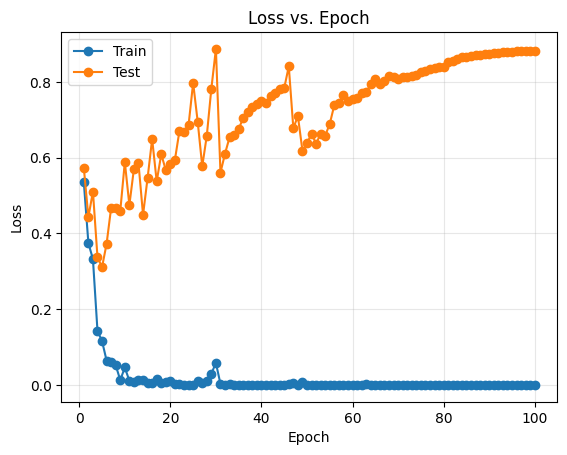

In [46]:
# 1️⃣  Loss curve
plt.close("all")                              # clear stale figures
plt.figure()
plt.plot(epochs, history["train_loss"], "o-", label="Train")
plt.plot(epochs, history["test_loss"],  "o-", label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=.3)
plt.legend()
plt.show()

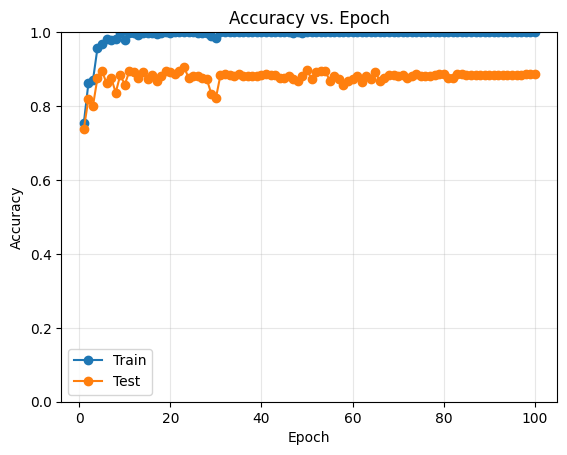

In [47]:
# 2️⃣  Accuracy curve
plt.figure()
plt.plot(epochs, history["train_accuracy"], "o-", label="Train")
plt.plot(epochs, history["test_accuracy"],  "o-", label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=.3)
plt.legend()
plt.show()

In [ ]:
# 3️⃣  Confusion matrix & classification report
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        logits = model(**inputs).logits
        preds  = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
labels = list(model.config.id2label.values())  # ["0", "1"] or custom names

# pretty print as a DataFrame
df_cm = pd.DataFrame(cm,
                     index=[f"True {l}" for l in labels],
                     columns=[f"Pred {l}" for l in labels])
display(df_cm.style.background_gradient(cmap="Blues").format("{:.0f}"))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=labels))

,Pred LABEL_0,Pred LABEL_1
True LABEL_0,126,13
True LABEL_1,18,118



Classification report:
              precision    recall  f1-score   support

     LABEL_0       0.88      0.91      0.89       139
     LABEL_1       0.90      0.87      0.88       136

    accuracy                           0.89       275
   macro avg       0.89      0.89      0.89       275
weighted avg       0.89      0.89      0.89       275

